# Screening Task 2
The goal of this task is to train a variational circuit to map four four qubit states, of my choosing to the states $|0011\rangle$, $|0101\rangle$, $|1010\rangle$ and $|1100\rangle$.
A variational circuit is a hybrid quantum classical model, where a quantum circuit is used to present any function and the parameters of the gates are trained and optimized classically. 
As I was new to this concept I partitioned the progess into three parts: 
* Modelling the identity function
* Modelling a general function
* Performance on unknown states
For this task I use pytorch and pennylane and the training is built on the written examples at https://pennylane.ai/qml/demos/tutorial_data_reuploading_classifier.html and Training a quantum circuit with Pytorch

To obtain a variational circuit we have to solve three parts:
* We first need to transform the input and output states into a form that can be used by Pennylane
* We need to define a loss function 
* Define the variational circuit. 

I first discuss the first two points and then define my first circuit.


## Preparing the states and defining a loss function
The output states are written in the braket notation, e.g. the state $|0011\rangle$ has values zero on the first two qubits and 1 on the last two. The actual Hilbert space is however represented by a basis of $2^n$ vectors.
For my loss function it is advantageous to get the representation of input and output states in this basis. 
For this I can create a quantum circuit that 

In [1]:
# Install pennylane. Uncomment if not yet installed.
# !pip install pennylane

In [2]:
# Import modules
import pennylane as qml
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt

# Set constants
n_qubits = 4
output_ket = np.array([[ 0, 0, 1, 1], [0, 1, 0, 1],
                        [1, 0, 1, 0], [1, 1, 0, 0]])

def input_layer(input_params):
  """
    Simple X, Y, Z layer that can create the input.

    Args:
        input_params (array[float]): 2-D array of angles for each qubit 
        
    Returns:
        None
    """
  for i in range(n_qubits):
    qml.RX(input_params[i, 0], wires=i)
    qml.RY(input_params[i, 1], wires=i)
    qml.RZ(input_params[i, 2], wires=i)

# Create output circuit
output_dev = qml.device("default.qubit", wires=4)
@qml.qnode(output_dev, interface="torch")
def states(ket):
  """Calculates the state and density matrix from braket notation.

    Args:
        ket (array[complex]): quantum state in braket representation

    Returns:
        state: 
    """
  output_params = np.zeros((n_qubits, 3))
  output_params[:, 1] = np.pi*ket
  input_layer(output_params)
  # Create state and density matrix
  return qml.state()


# Find all output states and the correspoding density matrices
output_states = [np.array(states(ket)).reshape(1, -1) for ket in output_ket]
output_matrices = [np.conj(state).T@state for state in output_states]

### Loss function and general circuit
My loss function should reward if the output state is close to the expected one. For this reason I use the fidelity, which compares the density matrix of the output of the circuit and the expcted density matrix. 
This measure would not be applicable in real Quantum Computers though. 
Alternatively, we could measure the expectation value of PauliZ, PauliY and PauliX gates for every qubit seperately and compare these values to the expected ones.

I also create a general form of a circuit, that takes the function of the layers as parameters and outputs the fidelity of two states. 
Lastly, I define a training with pytorch and some visualization of the losses.



In [3]:
# Loss function
def loss_fn(params, layer_func, input_params, n_layers):
  """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        layer_func (function): function that returns a circuit layer
        input_params (array[float]): 2D array of angles for creating input
        n_layers (int): number of layers included in circuit


    Returns:
        float: loss value to be minimized
  """
  loss = 0
  for j in range(4):
    fidelity = circuit(params, input_params[j], output_matrices[j], 
                       layer_func, n_layers)
    loss += (1-fidelity)**2
  return loss


# General circuit
dev = qml.device("default.qubit", wires=4)
@qml.qnode(dev, interface="torch")
def circuit(params, input_params, output_matrix, layer_func, n_layers):
  """Cost function to be minimized.

    Args:
        params (tensor[float]): autodifferentiable tensor of parameters
        input_params (array[float]): array of input parameters
        output_state (array[float]): density matrix of output state
        layer_func (function): function that returns a circuit layer
        n_layers (int): number of layers

    Returns:
        float: fidelity between output and expected output 
  """

  # Generate the input state
  input_layer(input_params)
  # repeatedly apply each layer in the circuit
  for j in range(n_layers):
      layer_func(params[j])
  # Return fidelity of output and expected output
  return qml.expval(qml.Hermitian(output_matrix, wires=[0, 1, 2, 3]))



def training(steps, n_layers, layer_func, params, input_params):
  """Training .

    Args:
        steps (int): number of optimization steps
        n_layers(int): number of layers
        layer_func (function): returns a single layer
        params (tensor[float]): autodifferentiable tensor of parameters
        input_params (array[float]): array of input parameters
    Returns:
        all_costs (array[float]): array of losses for all steps
        best_params (tensor):     tensor of parameters that minimize the loss
        params (tensor):          params of the last step
  """
  # set up the optimizer
  opt = torch.optim.Adam([params], lr=0.03)
  # the best parameters along the way
  best_cost = loss_fn(params, layer_func, input_params, n_layers)
  best_params = np.zeros((n_layers, n_qubits, 3))
  all_costs = []
  # optimization begins
  for n in range(steps):
      opt.zero_grad()
      loss = loss_fn(params, layer_func, input_params, n_layers)
      loss.backward()
      opt.step()
      all_costs.append(loss)
      # keeps track of best parameters
      if loss < best_cost:
          best_cost = loss
          best_params = params
  return all_costs, best_params, params


def plot_results(losses, best_params, title):
  """Plot the losses and print the best params in units of pi.

  """
  # Plot the cost and print best parameters
  plt.title(title)
  plt.ylabel("Cost")
  plt.xlabel("Steps")
  plt.plot(losses)
  plt.yscale('log')
  plt.show()
  print("Best parameters", best_params/np.pi, "Minimal Loss:", min(losses))

### Define layer functions
First we look at a layer consisting only of single qubit X rotations. This can be used to benchmark and see whether we get the expected results. 
Secondly, we define a full layer with X, Y, Z rotations and CNOT gates.
CNOT are multiqubits gates that can entangle different qubits. Although, I don't want to use entangled input states, their appearance in the circuit is crucial.
To see this we can consider the case that $|0000\rangle$ should be mapped to $|000\rangle$ and $|0100\rangle$ to $|1000\rangle$. In this case the first qubit is the same for both inputs but needs to be flipped depending on the second one. This shows that to represent a general function qubits need to be able share information.

In [4]:

def layer_x(layer_params):
  """Create single layer consisting RX acting on all qubits.

  Args:
      layer_params (tensor[float]): autodifferentiable tensor of parameters

  """
  for i in range(4):
    qml.RX(layer_params[i], wires=i)

def full_layer(layer_params):
  for i in range(4):
    qml.RX(layer_params[i, 0], wires=i)
    qml.RY(layer_params[i, 1], wires=i)
    qml.RZ(layer_params[i, 2], wires=i)
  qml.CNOT(wires=[0, 1])
  qml.CNOT(wires=[0, 2])
  qml.CNOT(wires=[0, 3])
  qml.CNOT(wires=[1, 2])
  qml.CNOT(wires=[1, 3])
  qml.CNOT(wires=[2, 3])



# Results
We now check the performance of the algorithm in five cases:
* input states == output states for single X layer
* input states == rotated output states with rotation around X and X layer
* input states == rotated output states with rotation around Y with X layer
* input states == permuted output states with X layer
* input states == permuted output states with full layer

In [5]:
### Prepare input states
# Input parameters for identity
state_input_identity = []
for i in range(4):
  input_params = np.zeros((n_qubits, 3))
  input_params[:, 1] = np.pi*output_ket[i]
  state_input_identity.append(input_params)
# Input parameters if rotated by pi/2 around x
state_input_rotationx = []
for input in state_input_identity:
  rotation_x = np.zeros((4, 3))
  rotation_x[:, 0] = 4 * [np.pi/2]
  state_input_rotationx.append(input+rotation_x)
# Input parameters if rotated by pi/2 around x
state_input_rotationy = []
for input in state_input_identity:
  rotation_y = np.zeros((4, 3))
  rotation_y[:, 1] = 4 * [np.pi/2]
  state_input_rotationy.append(input+rotation_y)
# Permutted input
permuted_state_input = state_input_identity[2:]
permuted_state_input.append(state_input_identity[1])
permuted_state_input.append(state_input_identity[0])

### Initialize parameters randomly from a normal distribution
# Single x layer
init_params_singlex = np.random.normal(0, np.pi, (1, n_qubits))
init_params_singlex = Variable(torch.tensor(init_params_singlex), requires_grad=True) 

# Full layer
n_layers = 5
init_params_full = np.random.normal(0, np.pi, (n_layers, n_qubits, 3))
init_params_full = Variable(torch.tensor(init_params_full), requires_grad=True) 


In [6]:
all_costs_identity, best_params_identity, params_identity = training(100, 1, layer_x, init_params_singlex, state_input_identity)
all_costs_rotationx, best_params_rotationx, params_rotationx = training(500, 1, layer_x, init_params_singlex, state_input_rotationx)
all_costs_rotationy, best_params_rotationy, params_rotationy = training(100, 1, layer_x, init_params_singlex, state_input_rotationy)
all_costs_permuted, best_params_permuted, params_permuted = training(100, 1, layer_x, init_params_singlex, permuted_state_input)
all_costs_full, best_params_full, params_full = training(500, 5, full_layer, init_params_full, permuted_state_input)

/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:149: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /pytorch/aten/src/ATen/native/Copy.cpp:240.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


## Single layer: Identity and rotations
I first look at the results for the single layer. 
The loss for the identity function goes well to zero and the best selected parameters are close to zero or 2 $\pi$ as expected.






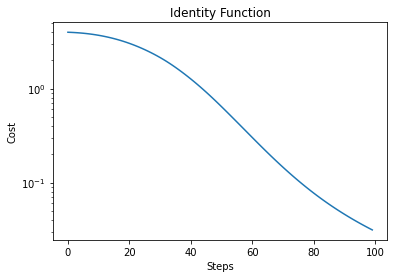

Best parameters tensor([[ 0.9528, -0.0064, -0.0013, -0.9529]], dtype=torch.float64,
       grad_fn=<DivBackward0>) Minimal Loss: tensor(0.0313, dtype=torch.float64, grad_fn=<AddBackward0>)


In [7]:
plot_results(all_costs_identity, best_params_identity, "Identity Function")

### X Rotation
Next I included the X rotation. The resulting error first falls, but then stops at around 3. This is not expected at all as the algorithm should be able to learn to apply the same rotation to the X gates. To me this indicates that unfortunatey there is still an error present.

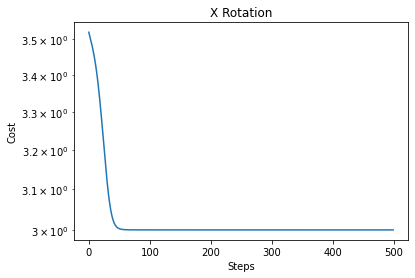

Best parameters tensor([[ 0.9528, -0.0064, -0.0013, -0.9529]], dtype=torch.float64,
       grad_fn=<DivBackward0>) Minimal Loss: tensor(3.0000, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([[ 2.9934, -0.0200, -0.0042, -2.9937]], dtype=torch.float64,
       requires_grad=True)


In [8]:
plot_results(all_costs_rotationx, best_params_rotationx, "X Rotation")
print(init_params_singlex)

### Y Rotation
If all input qubits are rotated around the y axis, then the error remains constant. This is what I had expected as rotation around Y is orthogonal to rotations around X. This means that we never could reach the expected state.

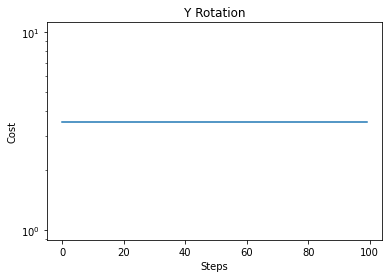

Best parameters [[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]] Minimal Loss: tensor(3.5156, dtype=torch.float64, grad_fn=<AddBackward0>)


In [9]:
plot_results(all_costs_rotationy, best_params_rotationy, "Y Rotation")

### Permutation
Here we looked at states that are permuted with again only one X layer. 
The error falls for the first few steps, but then remains constant. This is explained from the fact that by the chosen permutation there is no solution of choosing the X angles of the qubits such that all states would be correctly matched. Instead the algorithm just compromises on the closest solution. 

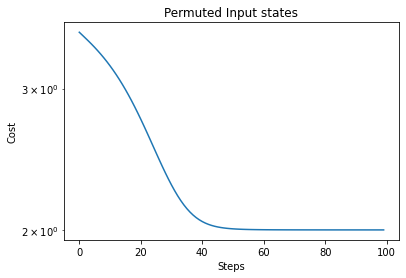

Best parameters tensor([[ 0.9528, -0.0064, -0.0013, -0.9529]], dtype=torch.float64,
       grad_fn=<DivBackward0>) Minimal Loss: tensor(2.0002, dtype=torch.float64, grad_fn=<AddBackward0>)


In [10]:
plot_results(all_costs_permuted, best_params_permuted, "Permuted Input states")

### Full Quantum Circuit
Lastly, we finally arrive at a full quantum circuit. We clearly see that with the number of steps increasing also the number the cost value goes down. 
The variational circuit performs better if more layers are given to the circuit.

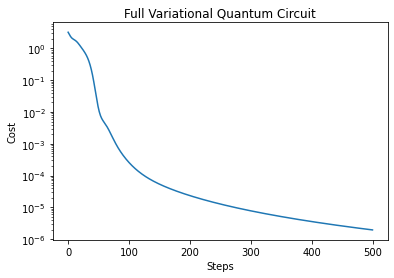

Best parameters tensor([[[-8.2941e-01, -7.9946e-01,  1.4695e+00],
         [ 1.5396e+00, -4.8383e-01,  4.6019e-01],
         [ 6.1034e-02,  5.0038e-01, -1.9390e+00],
         [-9.0971e-01, -9.4143e-02, -7.5007e-01]],

        [[-4.9411e-01, -6.9668e-01, -7.7655e-01],
         [ 9.7023e-02, -5.0176e-01,  1.0952e+00],
         [ 5.3449e-01, -4.9955e-01,  9.6564e-01],
         [-6.2632e-02, -9.3883e-01, -4.9998e-01]],

        [[-4.9977e-01, -2.2290e+00,  1.5420e+00],
         [-6.8281e-01, -2.2237e+00, -8.6435e-01],
         [ 1.0067e+00,  2.1797e-03,  1.6726e+00],
         [-9.9628e-02, -3.3065e-01, -9.6675e-01]],

        [[-1.5031e+00, -1.2164e+00,  2.5071e+00],
         [-1.0005e+00,  1.0001e+00, -1.8386e-02],
         [-6.9033e-01,  2.8691e-04, -2.0011e+00],
         [-1.9272e-02,  1.2209e+00, -5.0024e-01]],

        [[-1.3330e+00,  5.1056e-01, -6.7885e-01],
         [ 8.2648e-01, -4.9938e-01, -4.1229e-01],
         [-3.0970e-01, -9.9998e-01, -1.3025e+00],
         [ 6.6563e-02,  1.

In [11]:
plot_results(all_costs_full, best_params_full, "Full Variational Quantum Circuit")

# Discussion



## Critical Discussion
After completing this task I am left with two main worries: 

*X Rotation* 
 I can't at the moment explain why my single layer is not able to correctly approximate the rotated input state. 

*Practical Feasability* I had chosen to base my loss function on the fidelity after thinking for a long time how we can actually distinguish between quantum states. However, there are some downsides to that. First of all taking the expectation value of the Hermitian of the output might actually mean taking this as an input and therefore totally misunderstanding the task. Secondly, I am not yet aware how one would actually measure the "overlap" of density matrices in actual quantum computers. 
An older version of this program had used the x, y, z expectation values for all qubits as input and compared this to the loss function. Numerically this performed very well. Additionally, it should also be easier to implement in a real setting. 

## Unknown states
Once the variational circuit is trained it should be able to well categorize the four quantum states. 
What now happens if it is presented with an unknown state ? 
As our problem is quantum mechanical I can assume that if the new state is a superposition of already trained states, then also the output is a superposition.
Furthermore, as we had seen in the permutations with single layer, the network will predict the state that is closest to the expected outcome.

### Acknowledgments
Thanks for inviting me to do this screening task. I thoroughly enjoyed it and it actually really surprised in how many questions it made me ask and research, reigniting the joy of thinking and trying to understand. 